In [62]:
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

import warnings
warnings.filterwarnings("ignore")

In [63]:
# define VRP

n_customer = 15
n_point = n_customer + 1
vehicle_capacity = 4

df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
    'demand': np.random.randint(1, 2, n_point),
})

df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0
df.iloc[0]['demand'] = 0
df.iloc[-1]['x'] = 50
df.iloc[-1]['y'] = 50
df.iloc[15]['demand'] = 0

df

,x,y,demand
0,0,0,0
1,20,66,1
2,8,25,1
3,94,94,1
4,81,62,1
5,59,33,1
6,14,39,1
7,86,50,1
8,74,77,1
9,93,4,1


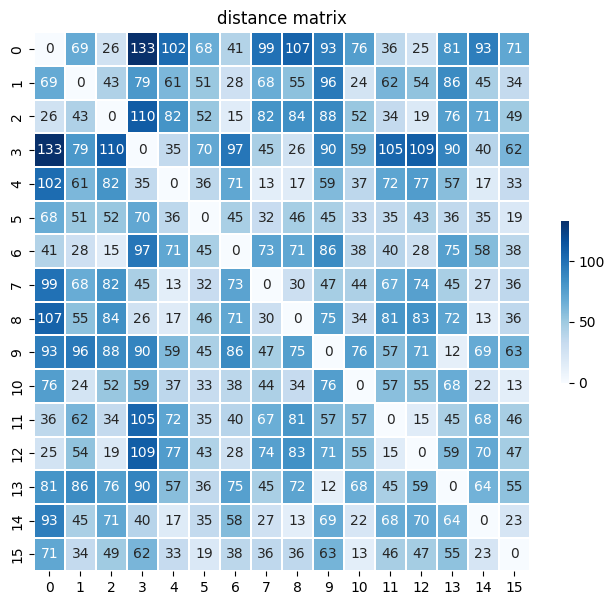

In [64]:
# get distance matrix

distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

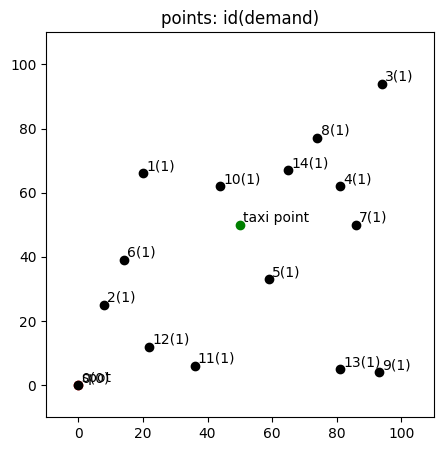

In [65]:
# check VRP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'spot')
    if i == 15:
        plt.scatter(row['x'], row['y'], c='green')
        plt.text(row['x'] + 1, row['y'] + 1, 'taxi point')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')
plt.show()

In [66]:
Npoint = 5

demands = df['demand'].values
tours = []
for length in range(2, Npoint):##length varies from 2 to n
    ##generates all possible combinations of a specified length
    tours += itertools.combinations(range(1,Npoint-1), length) 
print(tours)
for st in tours:##iterate over tours
    ## total demand in a given tour
    demand = np.sum([demands[s] for s in st]) ##total demand in a path st (s is a node)
    
print(demands[tours[0][0]])
print(n_point)

[(1, 2), (1, 3), (2, 3), (1, 2, 3)]
1
16


In [71]:
%%time

demands = df['demand'].values
vehicle_capacity = 6
# set problem
problem = pulp.LpProblem('cvrp_mip', pulp.LpMinimize)

# set variables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
n_vehicle = pulp.LpVariable('n_vehicle', lowBound=0, upBound=100, cat='Integer') ## no of vehicles
u = pulp.LpVariable.dicts('u', (i for i in range(1, n_point)), lowBound=0, cat='Continuous')

# set objective function
problem += pulp.lpSum([distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point)])

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0

for i in range(1, n_point):
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1 ## visit exactly once
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1

problem += pulp.lpSum(x[i, 0] for i in range(n_point)) == n_vehicle  ## return to hotspot
problem += pulp.lpSum(x[15, i] for i in range(n_point)) == n_vehicle ##exit from depot

##demands constraints
tours = []
for length in range(2, n_point):
    ## all possible combinations of a specified length
    tours += itertools.combinations(range(1,n_point-1), length) ##not included firsat and last

for st in tours: ##st a given path
    demand = np.sum([demands[s] for s in st]) ## s = node , sum of demands on a path
    arcs = [x[i, j] for i, j in itertools.permutations(st, 2)] ## 2 => pair (i,j) xij ==1 if i, j selected
    problem += pulp.lpSum(arcs) <= np.max([0, len(st) - np.ceil(demand / vehicle_capacity)]) ##demands <= aukaad constraints
    
# Subtour Elimination (MTZ constraints)
for i in range(1, n_point):
    problem += u[i] >= 1  # Ensures that each node (except the depot) is visited at least once
    problem += u[i] <= n_point - 1  # Sets an upper bound for u[i]
    
for i in range(1, n_point):
    for j in range(1, n_point):
        if i != j:
            problem += u[i] - u[j] + (n_point - 1) * x[i, j] <= n_point - 2
            
##constraint on number of vehicles
problem += n_vehicle <= 6
# solve problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective), pulp.value(n_vehicle)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/12d10a77708a4eb2904df733c2714fc0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/12d10a77708a4eb2904df733c2714fc0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16663 COLUMNS
At line 764081 RHS
At line 780740 BOUNDS
At line 780998 ENDATA
Problem MODEL has 16658 rows, 272 columns and 746663 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.24 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.42   (Wallclock seconds):       0.47

CPU times: user 2.91 s, sys: 99.7 ms, total: 3.01 s
Wall time: 3.49 s


(-1, 'Infeasible', 452.276794945761, 1.0)

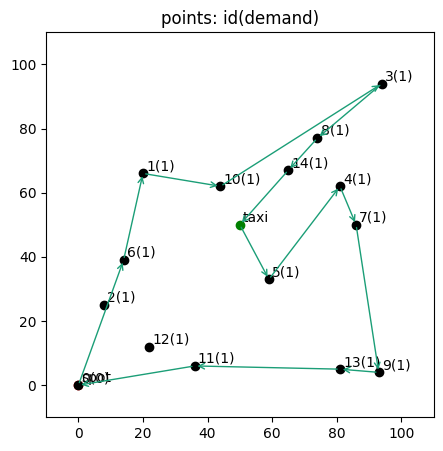

In [69]:
plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'spot')
    if i == 15:
        plt.scatter(row['x'], row['y'], c='green')
        plt.text(row['x'] + 1, row['y'] + 1, 'taxi')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')

# draw optimal route
cmap = matplotlib.cm.get_cmap('Dark2')
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]

for v in range(int(pulp.value(n_vehicle))):
    
    # identify the route of each vehicle
    vehicle_route = [routes[v]]
    while vehicle_route[-1][1] != 0:
        for p in routes:
            if p[0] == vehicle_route[-1][1]:
                vehicle_route.append(p)
                break

    # draw for each vehicle
    arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor=cmap(v))
    for i, j in vehicle_route:
        plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()